In [90]:
import pandas as pd
import xlrd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## Load and Clean Dataset

In [91]:
file = 'CaseStudy2data.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
unchanged_attrition_df = xl.parse('HR-employee-attrition Data')
attrition_df = unchanged_attrition_df

#drop unneccessary columns with constant values
attrition_column = attrition_df["Attrition"]
attrition_df.drop("Attrition", axis=1, inplace=True)
attrition_df.insert(0, "Attrition", attrition_column)
attrition_df.drop('EmployeeCount', axis=1, inplace=True)
attrition_df.drop('StandardHours', axis=1, inplace=True)
attrition_df.drop('Over18', axis=1, inplace=True)

#convert attrition variable to binary
attrition_df = attrition_df.replace("Yes", 1)
attrition_df = attrition_df.replace("No", 0)

# code dummy variables, this is necessary to use sklearn
attrition_df = pd.get_dummies(attrition_df, columns=["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus"], prefix=["BusinessTravel", "Department", "EduationField", "Gender", "JobRole", "MaritalStatus"])
df_without_attrition = attrition_df.drop("Attrition", axis=1)
columns_without_attrition = df_without_attrition.columns
columns_with_attrition = attrition_df.columns
attrition_df

Attrition  Age  DailyRate  DistanceFromHome  Education  EmployeeNumber  \
0             1   41       1102                 1          2               1   
1             0   49        279                 8          1               2   
2             1   37       1373                 2          2               4   
3             0   33       1392                 3          4               5   
4             0   27        591                 2          1               7   
5             0   32       1005                 2          2               8   
6             0   59       1324                 3          3              10   
7             0   30       1358                24          1              11   
8             0   38        216                23          3              12   
9             0   36       1299                27          3              13   
10            0   35        809                16          3              14   
11            0   29        153                15          2              15   
12            0   31        670                26          1              16   
13            0   34       1346                19          2              18   
14            1   28        103                24          3              19   
15            0   29       1389                21          4              20   
16            0   32        334                 5          2              21   
17            0   22       1123                16          2              22   
18            0   53       1219                 2          4              23   
19            0   38        371                 2          3              24   
20            0   24        673                11          2              26   
21            1   36       1218                 9          4              27   
22            0   34        419                 7          4              28   
23            0   21        391                15          2              30   
24            1   34        699                 6          1              31   
25            0   53       1282                 5          3              32   
26            1   32       1125                16          1              33   
27            0   42        691                 8          4              35   
28            0   44        477                 7          4              36   
29            0   46        705                 2          4              38   
30            0   33        924                 2          3              39   
31            0   44       1459                10          4              40   
32            0   30        125                 9          2              41   
33            1   39        895                 5          3              42   
34            1   24        813                 1          3              45   
35            0   43       1273                 2          2              46   
36            1   50        869                 3          2              47   
37            0   35        890                 2          3              49   
38            0   36        852                 5          4              51   
39            0   33       1141                 1          3              52   
40            0   35        464                 4          2              53   
41            0   27       1240                 2          4              54   
42            1   26       1357                25          3              55   
43            0   27        994                 8          3              56   
44            0   30        721                 1          2              57   
45            1   41       1360                12          3              58   
46            0   34       1065                23          4              60   
47            0   37        408                19          2              61   
48            0   46       1211                 5          4              62   
49    

## Split into Train and Test Set

In [92]:
rand = np.random.rand(len(attrition_df)) < 0.8

train = attrition_df[rand]
test = attrition_df[~rand]

print(train.shape)
print(test.shape)

(1179, 52)
(291, 52)


## Correlation Matrix to Identify Covariance

In [93]:
train.corr().abs()

Attrition       Age  DailyRate  \
Attrition                           1.000000  0.150145   0.012357   
Age                                 0.150145  1.000000   0.014475   
DailyRate                           0.012357  0.014475   1.000000   
DistanceFromHome                    0.101155  0.011709   0.018485   
Education                           0.029104  0.196421   0.018727   
EmployeeNumber                      0.004582  0.017453   0.068488   
EnvironmentSatisfaction             0.104622  0.005416   0.009644   
HourlyRate                          0.009991  0.011990   0.026559   
JobInvolvement                      0.126867  0.032916   0.054674   
JobLevel                            0.165205  0.501692   0.009540   
JobSatisfaction                     0.101341  0.026868   0.020823   
MonthlyIncome                       0.154012  0.491140   0.011084   
MonthlyRate                         0.001587  0.037468   0.024996   
NumCompaniesWorked                  0.033004  0.313779   0.037224   
OverTime                            0.236743  0.034226   0.036659   
PercentSalaryHike                   0.024040  0.013461   0.033523   
PerformanceRating                   0.006272  0.023849   0.026457   
RelationshipSatisfaction            0.042609  0.073407   0.007357   
StockOptionLevel                    0.119311  0.034440   0.022600   
TotalWorkingYears                   0.172416  0.677420   0.006903   
TrainingTimesLastYear               0.038384  0.021130   0.033448   
WorkLifeBalance                     0.056180  0.047228   0.036581   
YearsAtCompany                      0.133675  0.296132   0.041574   
YearsInCurrentRole                  0.153980  0.207854   0.000975   
YearsSinceLastPromotion             0.017024  0.203014   0.061220   
YearsWithCurrManager                0.148609  0.197339   0.028541   
BusinessTravel_Non-Travel           0.072085  0.003646   0.002385   
BusinessTravel_Travel_Frequently    0.137656  0.023304   0.015180   
BusinessTravel_Travel_Rarely        0.070898  0.022512   0.011508   
Department_Human Resources          0.018687  0.003061   0.007298   
Department_Research & Development   0.107831  0.005010   0.000061   
Department_Sales                    0.103369  0.006593   0.003389   
EduationField_Human Resources       0.031207  0.005485   0.015364   
EduationField_Life Sciences         0.016993  0.023578   0.000820   
EduationField_Marketing             0.060135  0.030818   0.055661   
EduationField_Medical               0.062030  0.001367   0.031154   
EduationField_Other                 0.008004  0.046237   0.002040   
EduationField_Technical Degree      0.056657  0.030127   0.018998   
Gender_Female                       0.035631  0.042100   0.001098   
Gender_Male                         0.035631  0.042100   0.001098   
JobRole_Healthcare Representative   0.091259  0.089834   0.034500   
JobRole_Human Resources             0.032935  0.035073   0.005746   
JobRole_Laboratory Technician       0.086088  0.132934   0.007712   
JobRole_Manager                     0.090047  0.276223   0.015016   
JobRole_Manufacturing Director      0.062434  0.029265   0.007922   
JobRole_Research Director           0.081640  0.196996   0.001826   
JobRole_Research Scientist          0.021001  0.155344   0.029234   
JobRole_Sales Executive             0.031371  0.014429   0.012630   
JobRole_Sales Representative        0.190757  0.164411   0.001070   
MaritalStatus_Divorced              0.083838  0.015348   0.013002   
MaritalStatus_Married               0.075351  0.086252   0.034598   
MaritalStatus_Single                0.154778  0.105313   0.048345   

                                   DistanceFromHome  Education  \
Attrition                                  0.101155   0.029104   
Age                                        0.011709   0.196421   
DailyRate                                  0.018485   0.018727   
DistanceFromHome                           1.000000   0.037154   
Education                                  0.03

Based off looking at the correlation matrix above, there are not any values that stand out as extremly correlated (0.8). Thus no variables will be removed.

## Recursive Feature Elimination

In [94]:
np.set_printoptions(precision=3)

values = train.values

X = values[:,1:(len(train.columns))]
Y = values[:,0]

test_values = test.values
X_test = test_values[:,1:(len(test.columns))]
Y_test = test_values[:,0]


number_of_features_to_select = 5
# feature extraction
model = LogisticRegression()
rfe = RFE(model, number_of_features_to_select)
fit = rfe.fit(X, Y)
print(fit.support_)
print(fit.ranking_)
true_indexes = [i for i, x in enumerate(fit.support_) if x == True]
features = np.asarray(columns_without_attrition[true_indexes])
print(features)

predictions = rfe.predict(X_test)
print('Accuracy of RFE on test set: {:.5f}'.format(fit.score(X_test, Y_test)))


[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False  True False  True False False  True
 False False False]
[39 46 36 38 45 11 42  7 35 13 44 47 29  1 37 30 21 19 31 26 14 34 23 24
 32  6  3 22 17 43  9  4 41 25 16 40 10 20 12  1  8  5  1 28  1 33 18  1
 27 15  2]
['OverTime' 'JobRole_Healthcare Representative' 'JobRole_Manager'
 'JobRole_Research Director' 'JobRole_Sales Representative']
Accuracy of RFE on test set: 0.81787


## Feature Importance With ExtraTreesClassifier

In [95]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier()
fit = model.fit(X, Y)

importances = model.feature_importances_
print(importances)

idxs = np.argsort(importances)[-(number_of_features_to_select):]
features = np.asarray(columns_without_attrition[idxs])
print(list(reversed(features.tolist())))

predictions = model.predict(X_test)
print('Accuracy of extra trees classifier on test set: {:.5f}'.format(model.score(X_test, Y_test)))


[0.033 0.03  0.03  0.025 0.028 0.036 0.028 0.028 0.026 0.031 0.028 0.03
 0.024 0.054 0.025 0.009 0.035 0.022 0.036 0.022 0.03  0.029 0.028 0.029
 0.031 0.006 0.018 0.015 0.006 0.011 0.008 0.005 0.016 0.012 0.013 0.006
 0.01  0.012 0.015 0.003 0.007 0.019 0.005 0.007 0.002 0.008 0.005 0.022
 0.005 0.014 0.02 ]
['OverTime', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'RelationshipSatisfaction', 'Age']
Accuracy of extra trees classifier on test set: 0.84192


## Random Forrest

In [96]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X, Y)

clf.predict(X_test)

# preds = iris.target_names[clf.predict(test[features])]
train.describe()
test.describe()
preds = clf.predict_proba(X_test)

predictions = []
attrition_count = 0
not_attrition_count = 0
for pred in preds:
    if pred[0] >= pred[1]:
        not_attrition_count = not_attrition_count + 1
        predictions.append('No Attrition') 
    else:
        attrition_count = attrition_count + 1
        predictions.append('Attrition')
    
print("Attrition count: ")
print(attrition_count)
print("Not Attrition count: ")
print(not_attrition_count)
print('Accuracy of random forrest on test set: {:.5f}'.format(clf.score(X_test, Y_test)))
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), columns_without_attrition), reverse=True)[:5])



Attrition count: 
7
Not Attrition count: 
284
Accuracy of random forrest on test set: 0.82818
[(0.073, 'MonthlyIncome'), (0.0556, 'Age'), (0.0519, 'DistanceFromHome'), (0.0508, 'DailyRate'), (0.0489, 'TotalWorkingYears')]


## Logistic Regression

In [97]:
logreg = LogisticRegression()
logreg.fit(X, Y)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, Y_test)))


Accuracy of logistic regression classifier on test set: 0.82131


In [98]:
denom = (2.0*(1.0+np.cosh(logreg.decision_function(X))))
F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
z_scores = logreg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

print(sorted(list(zip(p_values, columns_without_attrition)))[:5])

[(6.273883525573382e-05, 'YearsSinceLastPromotion'), (9.455076590116655e-05, 'DistanceFromHome'), (0.0012356628507122769, 'NumCompaniesWorked'), (0.012165317860111708, 'YearsInCurrentRole'), (0.017813868555030695, 'EnvironmentSatisfaction')]


/Users/mihirparikh/.local/share/virtualenvs/case_study_two-VwQshxTY/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


## Data Exploration

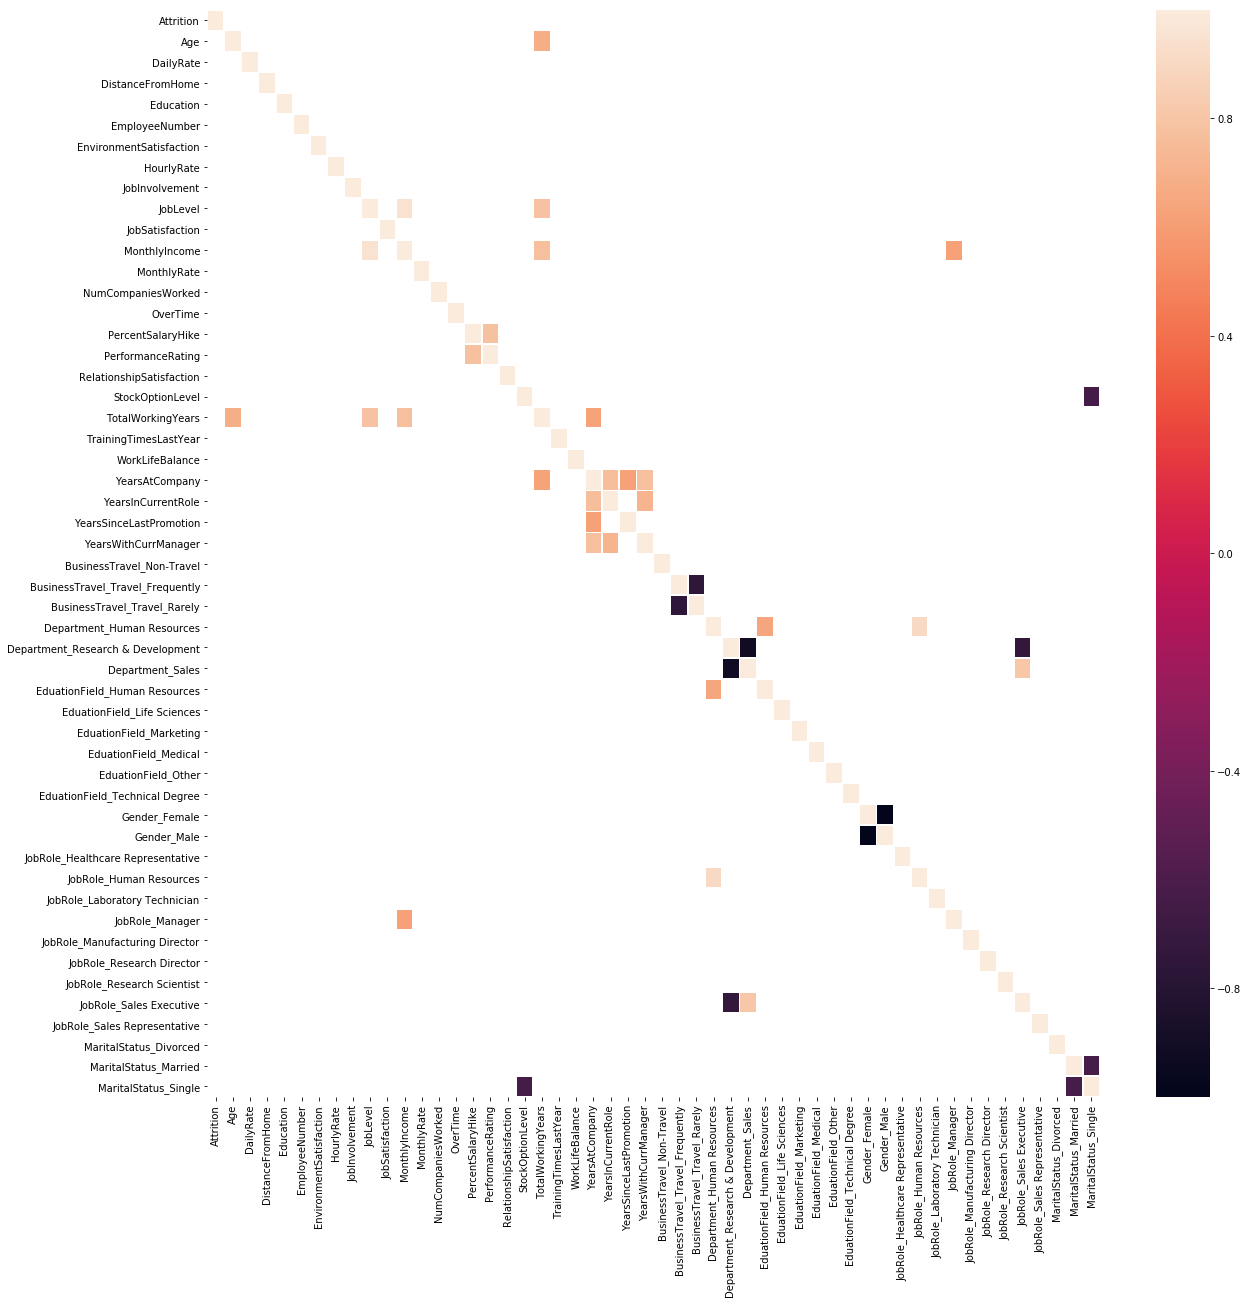

In [99]:
plt.figure(figsize = (20,20))
corr = attrition_df.corr()
sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.6)], 
        xticklabels=columns_with_attrition,
        yticklabels=columns_with_attrition, linewidths=.6)

There does not appear to be a high degree of correlation between different factor that warrant removal of certain factors. All factors will be left in for further analysis.

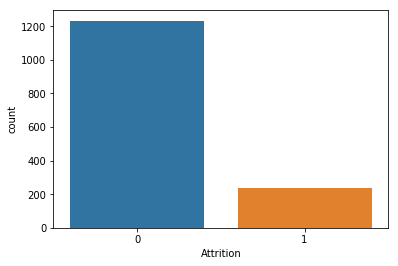

In [100]:
sns.countplot(x='Attrition',data=attrition_df)
plt.show()

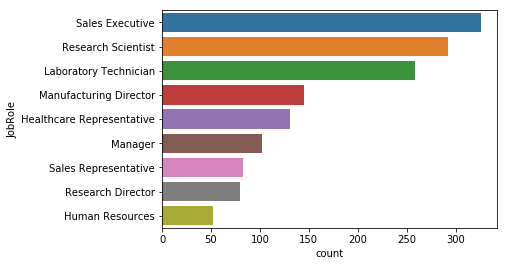

In [101]:
sns.countplot(y="JobRole", data=unchanged_attrition_df)
plt.show()

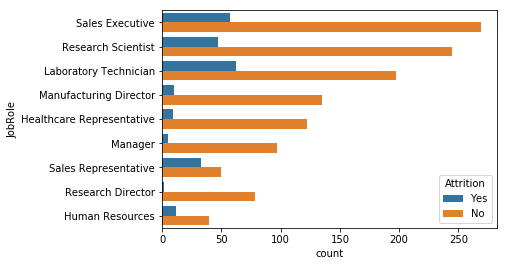

In [102]:
sns.countplot(y="JobRole", hue="Attrition", data=unchanged_attrition_df)

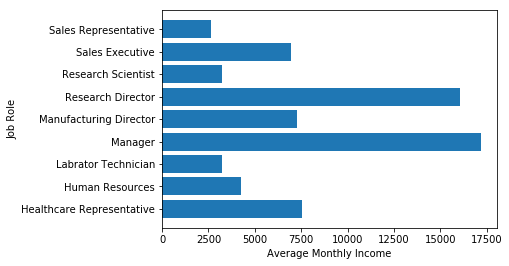

In [103]:
income = unchanged_attrition_df.groupby('JobRole').mean()[['MonthlyIncome']].values
flattened_income = []
for i in income:
    flattened_income.append(i[0])
    
roles = ['Healthcare Representative', 'Human Resources', 'Labrator Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist' , 'Sales Executive','Sales Representative']

y_pos = np.arange(len(roles))

plt.xlabel('Average Monthly Income')
plt.ylabel('Job Role')
 
# Create horizontal bars
plt.barh(y_pos, flattened_income)
 
# Create names on the y-axis
plt.yticks(y_pos, roles)
 
# Show graphic
plt.show()



## Interesting Trends

We will looks at trends in job roles vs some of the factors that were selected in the different models.

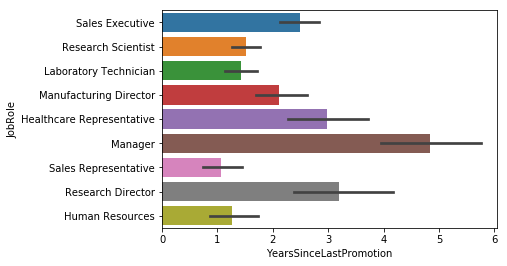

In [104]:
sns.barplot(x="YearsSinceLastPromotion", y="JobRole", data=unchanged_attrition_df)

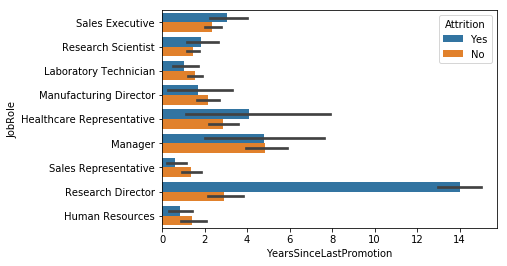

In [105]:
sns.barplot(x="YearsSinceLastPromotion", y="JobRole",hue= "Attrition", data=unchanged_attrition_df)

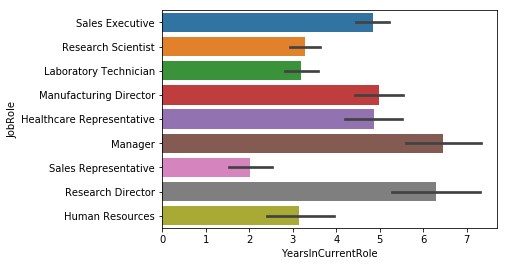

In [106]:
sns.barplot(x="YearsInCurrentRole", y="JobRole", data=unchanged_attrition_df)

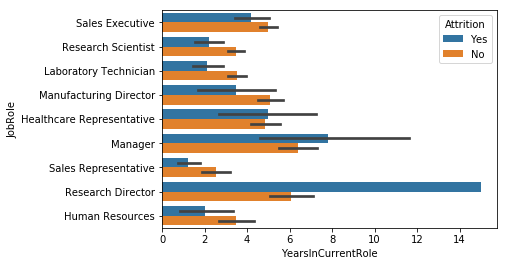

In [107]:
sns.barplot(x="YearsInCurrentRole", y="JobRole", hue= "Attrition", data=unchanged_attrition_df)

In [108]:
unchanged_attrition_df.corr()[["YearsSinceLastPromotion"]]["YearsInCurrentRole":"YearsInCurrentRole"]

YearsSinceLastPromotion
YearsInCurrentRole                 0.548056

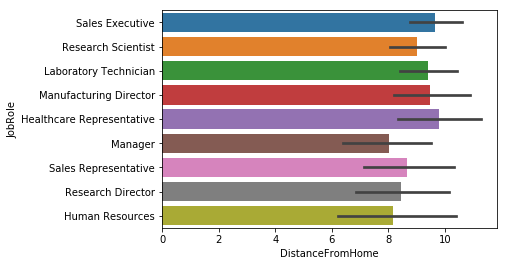

In [109]:
sns.barplot(x="DistanceFromHome", y="JobRole", data=unchanged_attrition_df)

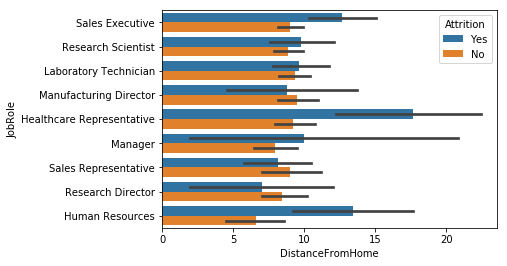

In [110]:
sns.barplot(x="DistanceFromHome", y="JobRole", hue= "Attrition", data=unchanged_attrition_df)

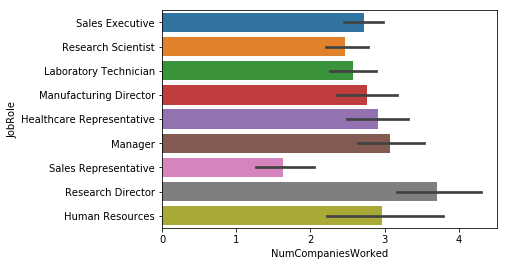

In [111]:
sns.barplot(x="NumCompaniesWorked", y="JobRole", data=unchanged_attrition_df)

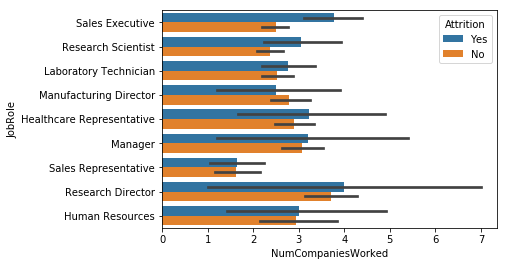

In [112]:
sns.barplot(x="NumCompaniesWorked", y="JobRole", hue="Attrition", data=unchanged_attrition_df)

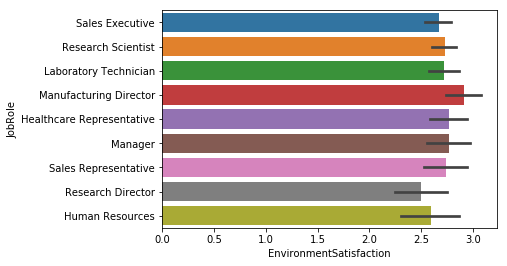

In [113]:
sns.barplot(x="EnvironmentSatisfaction", y="JobRole", data=unchanged_attrition_df)

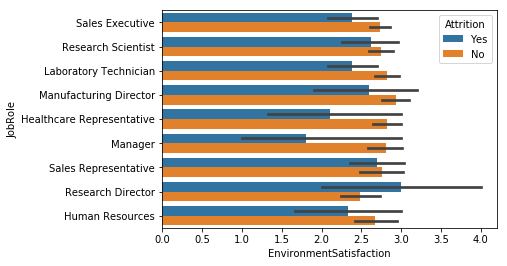

In [114]:
sns.barplot(x="EnvironmentSatisfaction", y="JobRole",hue= "Attrition", data=unchanged_attrition_df)

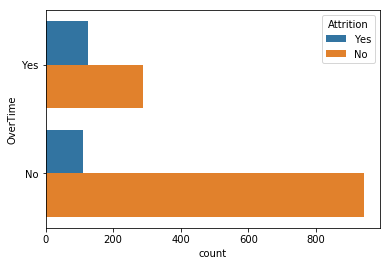

In [115]:
sns.countplot(y="OverTime", hue="Attrition", data=unchanged_attrition_df)

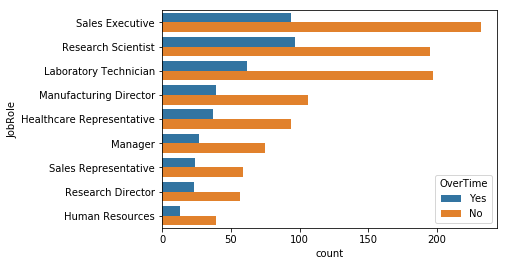

In [116]:
sns.countplot(y="JobRole", hue="OverTime", data=unchanged_attrition_df)

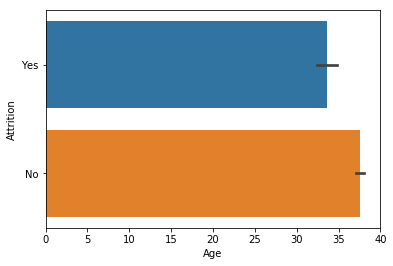

In [117]:
sns.barplot(x="Age", y="Attrition", data=unchanged_attrition_df)

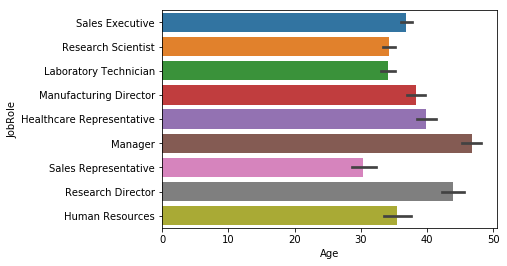

In [118]:
sns.barplot(x="Age", y="JobRole", data=unchanged_attrition_df)

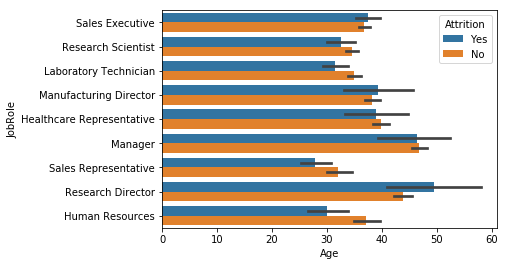

In [119]:
sns.barplot(x="Age", y="JobRole", hue="Attrition", data=unchanged_attrition_df)